In [43]:
import numpy as np
import xlrd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import molmass
import warnings

# Gathering Data

In [2]:
# reading_data
data_wb = xlrd.open_workbook('CHE223-Assignment1 for 2023-data sets up to 2019.xls')

# Finding Columns of Ions and Postal Codes
ion_dict = {}
postal_code = {}
all_ions = set()
ion_year = {}

for sheet in data_wb.sheets():

    year = ''
    for char in sheet.name:
        if char.isdigit(): year += char
    year = int(year)

    ions = []
    for row in np.arange(11):
        for col in np.arange(sheet.ncols):
            value = sheet.cell_value(row,col)

            if type(value) is str:
                if len(value)<=3:
                    try :
                        molmass.Formula(value)._elements
                        ions.append((year, col, row, value))
                        all_ions.add(value)
                        
                    except: pass
                elif 'postal' in value.lower():
                    postal_code[sheet] = col

    ion_dict[sheet] = ions
    
all_ions = list(all_ions)
all_ions.sort()

In [3]:
# iterate through rows and record values based on (column, ion) pairs

data = []

for sheet in data_wb.sheets():
    for i in np.arange(len(ion_dict[sheet])):

        ion_tuple = ion_dict[sheet][i]
        for row in np.arange(ion_dict[sheet][i][2]+1, sheet.nrows):

            value = sheet.cell_value(row,ion_dict[sheet][i][1])

            # Data cleaning
            if type(value) is str:
                if 'n' in value.lower() or '-' in value or value.strip() == '':
                    value = np.nan
                
                elif value.endswith('ppm'):
                    value = float(value.strip('ppm'))

                elif '..' in value:
                    value = float(value.replace('..','.'))

                elif '. ' in value:
                    value = float(value.replace('. ','.'))
                
                elif '^' in value:
                    value = float(value[0:4]) * 10 ** int(value[-1])

            if sheet in postal_code:
                pocode = sheet.cell_value(row, postal_code[sheet]).strip().upper()[0:3]
                
                if pocode.strip() == '':
                    pocode = np.nan

            else:
                pocode = np.nan
            
            # Empty entries and negative entries  are excluded immediately 
            if value is not np.nan and not value < 0:
                data.append([ion_tuple[0], ion_tuple[3], value, pocode])



df = pd.DataFrame(data, columns=['Year', 'Ion', 'Conc (mg/L)', 'Postal Code'])

# Plots

## Raw

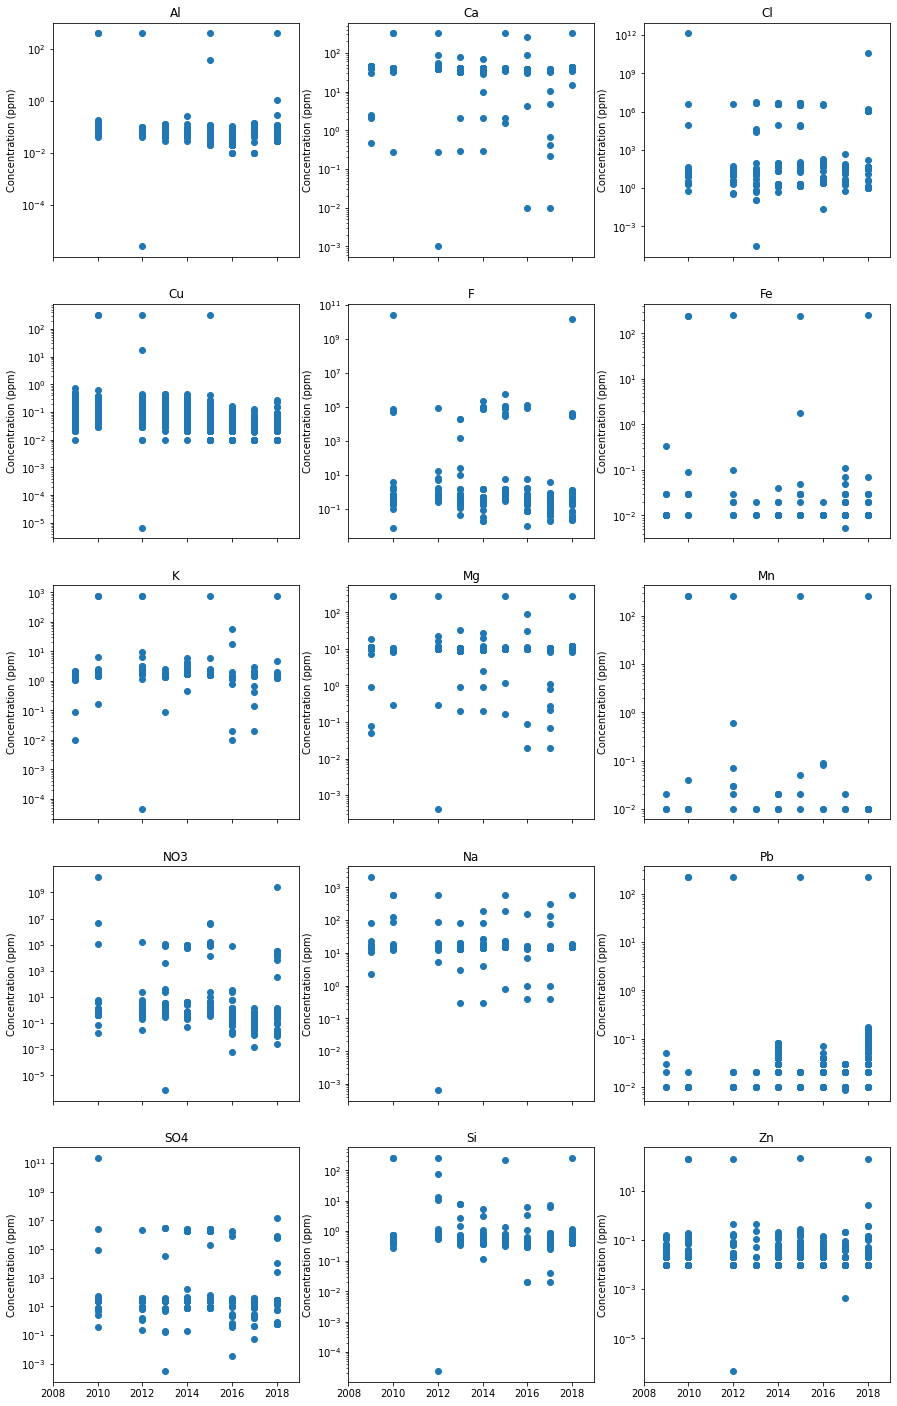

In [5]:
most_ions = [ion for ion in all_ions if ion not in ('Ag', 'As', 'Cd', 'Co', 'Ni', 'Ti')]


fig, axs = plt.subplots(5, 3, figsize=(15,25), sharex=True)
row = 0
col = 0
for ion in most_ions:
    axs[row, col].semilogy(df[(df['Ion'] == ion)]['Year'], df[(df['Ion'] == ion)]['Conc (mg/L)'], ls='', marker='o')
    axs[row, col].set_title(ion)
    axs[row, col].set_xlim(2008, 2019)
    axs[row, col].set_ylabel('Concentration (ppm)')
    
    if col == 2: 
        col = 0
        row += 1
    else: col += 1

fig.savefig('Scatter.png')

In [6]:
df[(df['Ion'] == 'Fe') & (df['Conc (mg/L)'] < df[(df['Ion'] == ion)]['Conc (mg/L)'].quantile(0.99))]['Conc (mg/L)'].describe()

count    949.000000
mean       0.002840
std        0.008744
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.110000
Name: Conc (mg/L), dtype: float64

## Log 

<AxesSubplot:>

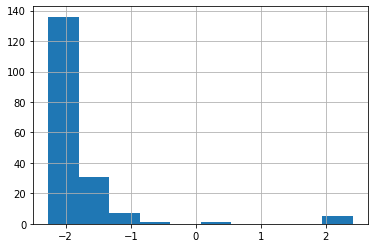

In [7]:
df_log = df.copy()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df_log['Conc (mg/L)'] = np.log10(df_log['Conc (mg/L)'])

for ion in all_ions:
    iqr = ( df_log[(df_log['Ion'] == ion) & (df_log['Conc (mg/L)'] != -np.inf)]['Conc (mg/L)'].quantile(0.75)
            - df_log[(df['Ion'] == ion)& (df_log['Conc (mg/L)'] != -np.inf)]['Conc (mg/L)'].quantile(0.25) )
    # print(ion, iqr)

df_log[(df_log['Ion'] == 'Fe') & (df_log['Conc (mg/L)'] != -np.inf)]['Conc (mg/L)'].hist()

<AxesSubplot:title={'center':'Conc (mg/L)'}, xlabel='Year'>

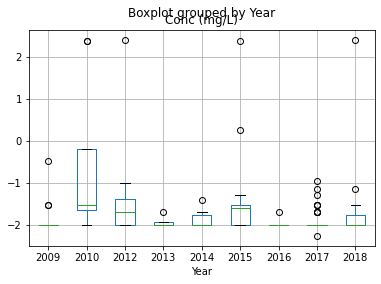

In [8]:
df_log[(df['Ion'] == 'Fe') & (df['Conc (mg/L)'] != 0)].boxplot(by='Year', column=['Conc (mg/L)'])

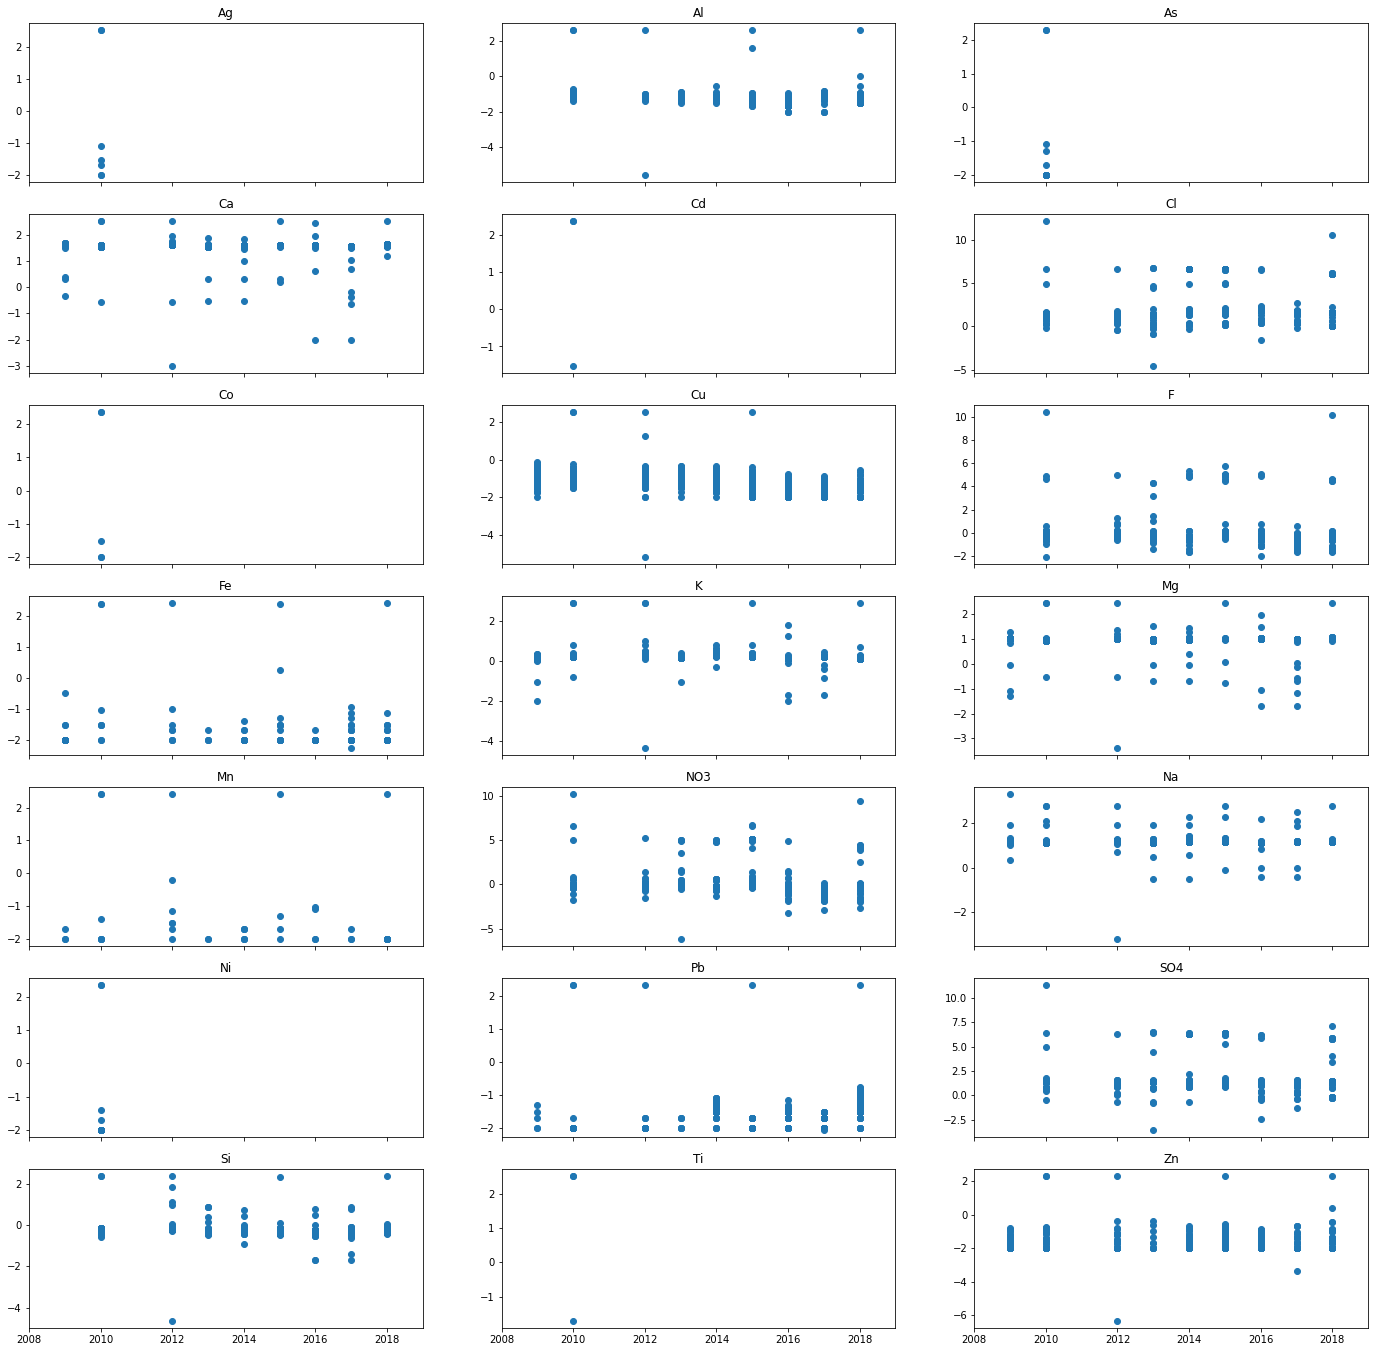

In [9]:
fig, axs = plt.subplots(7, 3, figsize=(24,24), sharex=True)
row = 0
col = 0

for ion in all_ions:
    axs[row, col].plot(df_log[(df['Ion'] == ion)]['Year'], df_log[(df['Ion'] == ion)]['Conc (mg/L)'], ls='', marker='o')
    axs[row, col].set_title(ion)
    axs[row, col].set_xlim(2008, 2019)

    if col == 2: 
        col = 0
        row += 1
    else: col += 1
    

## Inverse

In [10]:
df_inverse = df[(df['Conc (mg/L)'] != 0)]
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df_inverse['Conc (mg/L)'] = 1/(df_inverse['Conc (mg/L)'])

for ion in all_ions:
    # iqr = ( df_inverse[(df_inverse['Ion'] == ion)]['Conc (mg/L)'].quantile(0.75)
    #         - df_inverse[(df['Ion'] == ion)]['Conc (mg/L)'].quantile(0.25) )
    # print(ion, iqr)
    print(ion, df_inverse[(df_inverse['Ion'] == ion)]['Conc (mg/L)'].describe())

Ag count      7.000000
mean      42.262776
std       43.328908
min        0.003048
25%        6.251524
50%       33.333333
75%       75.000000
max      100.000000
Name: Conc (mg/L), dtype: float64
Al count       595.000000
mean        668.162564
std       15827.786757
min           0.002524
25%          12.500000
50%          16.666667
75%          25.000000
max      386100.386100
Name: Conc (mg/L), dtype: float64
As count     13.000000
mean      67.885429
std       43.919092
min        0.005292
25%       20.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: Conc (mg/L), dtype: float64
Ca count    1001.000000
mean        1.251263
std        31.873543
min         0.003145
25%         0.024975
50%         0.026323
75%         0.027701
max       998.701688
Name: Conc (mg/L), dtype: float64
Cd count     3.000000
mean     11.114025
std      19.242486
min       0.004371
25%       0.004371
50%       0.004371
75%      16.668852
max      33.333333
Name: Conc (mg/L), dtype:

C:\Users\enlb2\AppData\Local\Temp\ipykernel_7092\3433801163.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axs[row, col].plot(df_inverse[(df['Ion'] == ion)]['Year'],df_inverse[(df['Ion'] == ion)]['Conc (mg/L)'], ls='', marker='o')


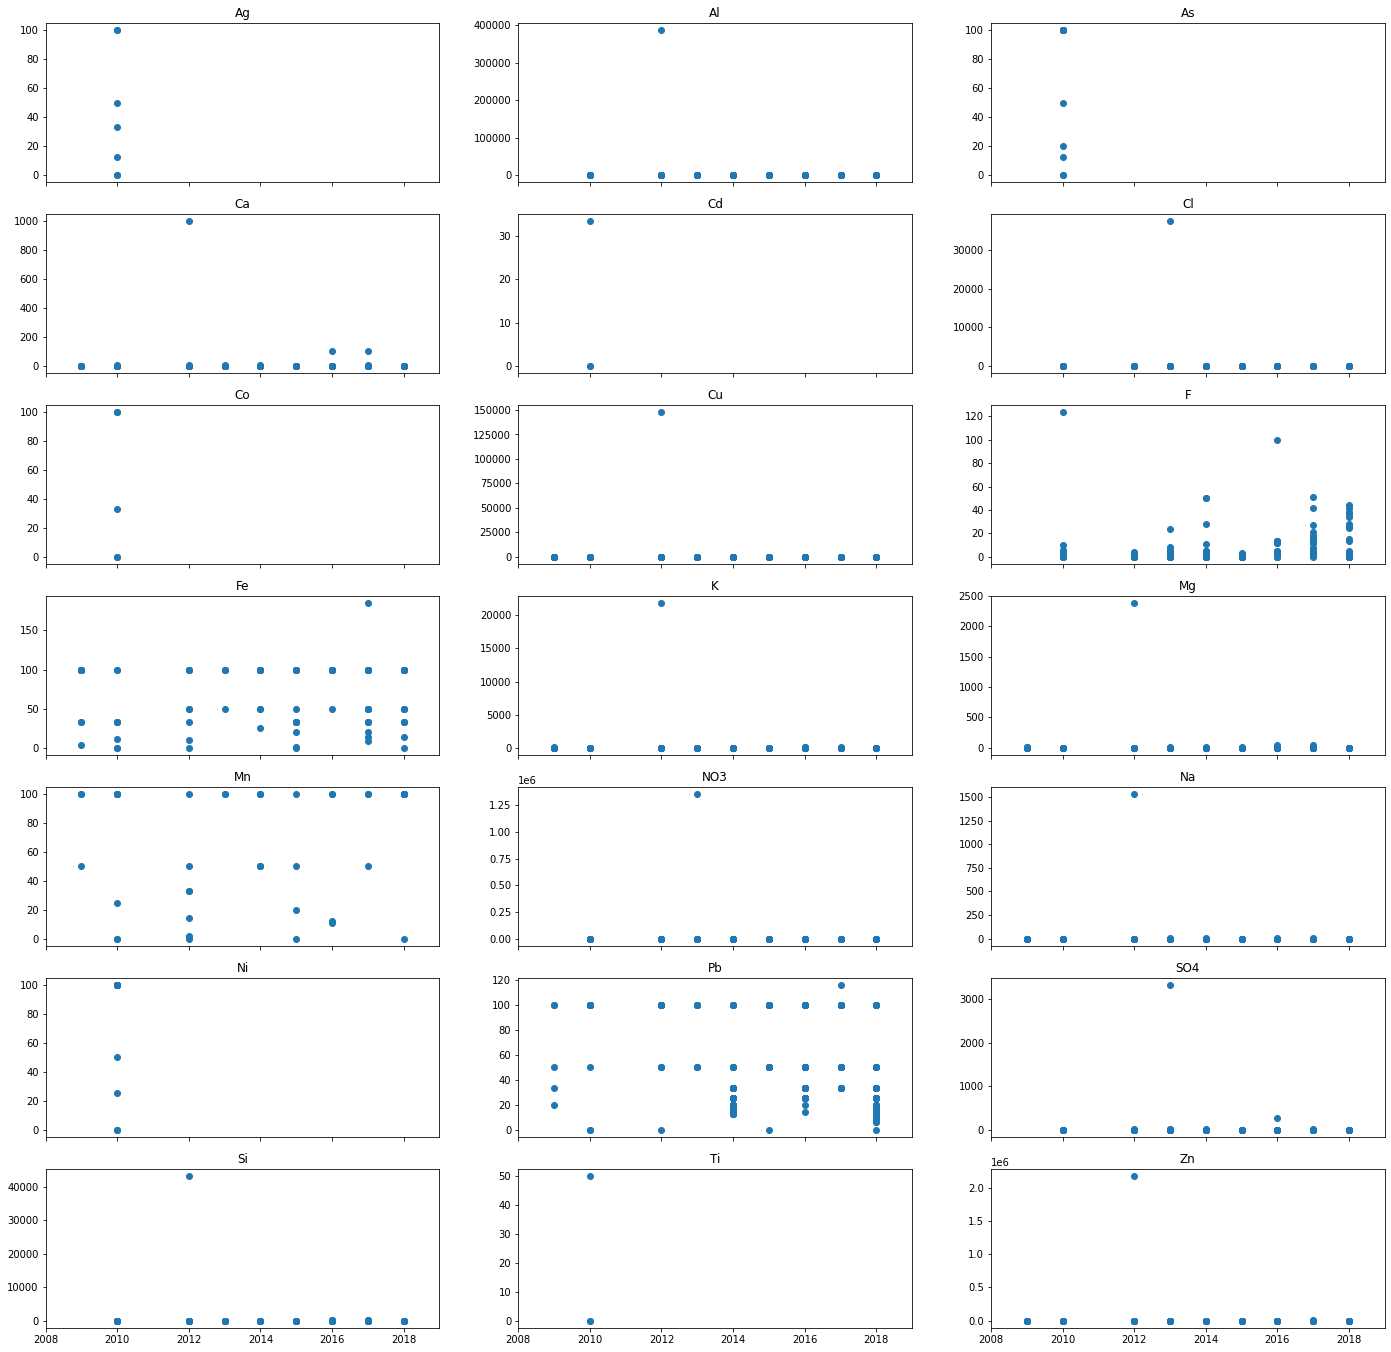

In [11]:
fig, axs = plt.subplots(7, 3, figsize=(24,24), sharex=True)
row = 0
col = 0

for ion in all_ions:
    axs[row, col].plot(df_inverse[(df['Ion'] == ion)]['Year'],df_inverse[(df['Ion'] == ion)]['Conc (mg/L)'], ls='', marker='o')
    axs[row, col].set_title(ion)
    axs[row, col].set_xlim(2008, 2019)

    if col == 2: 
        col = 0
        row += 1
    else: col += 1

## Coefficient of Variation

In [12]:
cv_data = []

for year in ion_dict.values():

    for yr, c, r, ion in year:

        mean = df[(df['Ion'] == ion) & (df['Year'] == yr)]['Conc (mg/L)'].mean()
        std_dev = df[(df['Ion'] == ion) & (df['Year'] == yr)]['Conc (mg/L)'].std()
        cv = std_dev / mean
        
        cv_data.append([yr, ion, mean, std_dev, cv])

df_summary = pd.DataFrame(cv_data, columns=['Year', 'Ion', 'Mean', 'Standard Deviation', 'Coefficient of Variation'])
df_summary

,Year,Ion,Mean,Standard Deviation,Coefficient of Variation
0,2018,Ca,43.744083,30.511071,0.697490
1,2018,Cu,0.046047,0.059487,1.291900
2,2018,Fe,3.099750,28.361094,9.149478
3,2018,K,10.631905,83.465386,7.850464
4,2018,Mg,14.303488,29.920833,2.091856
...,...,...,...,...,...
130,2009,Mg,10.122976,2.170461,0.214409
131,2009,Mn,0.000476,0.002646,5.555850
132,2009,Na,40.302262,223.867490,5.554713
133,2009,Pb,0.004444,0.011547,2.598076


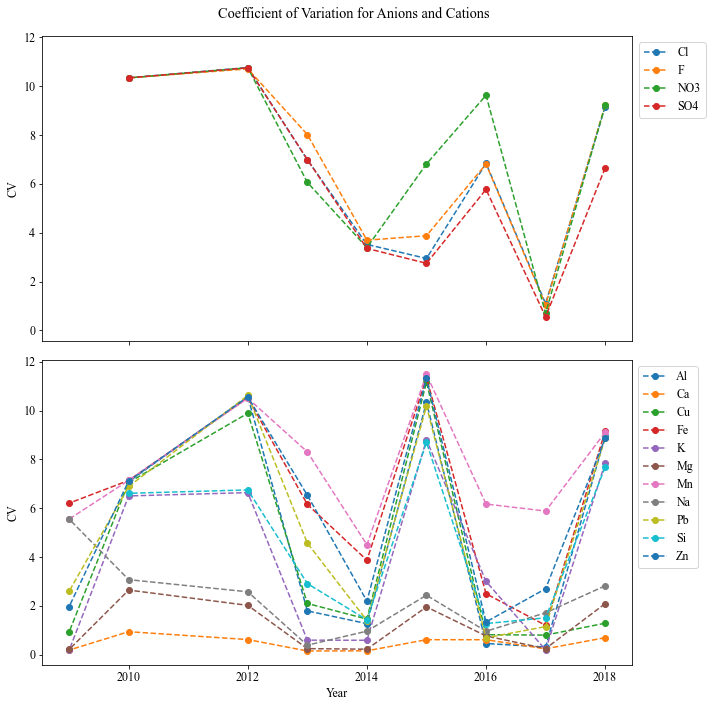

In [48]:
anions = ['Cl', 'F', 'NO3', 'SO4']
cations = [ion for ion in most_ions if ion not in anions]

mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12


fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,10), sharey=True, sharex=True, tight_layout=True)

fig.suptitle('Coefficient of Variation for Anions and Cations')

for ion in anions:
    x = df_summary[df_summary['Ion'] == ion]['Year']
    y = df_summary[df_summary['Ion'] == ion]['Coefficient of Variation']

    ax1.plot(x,y, '--o', label=ion)
    ax2.set_xlabel('Year')
    ax1.set_ylabel('CV')

ax1.legend(bbox_to_anchor=(1.135, 1))

for ion in cations:
    x = df_summary[df_summary['Ion'] == ion]['Year']
    y = df_summary[df_summary['Ion'] == ion]['Coefficient of Variation']

    ax2.plot(x,y, '--o', label=ion)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('CV')

ax2.legend(bbox_to_anchor=(1, 1))

plt.show()

## end